In [1]:
import json
import pickle
import re
#import cv2 as cv

In [3]:
with open('files.json') as f:
    img_files = json.load(f)

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_files, test_size = 0.2)
val, test = train_test_split(test, test_size = 0.5)

In [5]:
img_dict = {}
img_dict['train'] = train
img_dict['val'] = val
img_dict['test'] = test

In [26]:
with open('img_dict.json', 'w') as f:
    json.dump(img_dict, f)

In [13]:
import shutil
import os

In [23]:
for img in img_dict['train']:
    image = img[:6]
    shutil.copy2(f"data/OCH/ochuman/{image}.jpg", f"data/OCH/train_test_val/train/{image}.jpg")

for img in img_dict['val']:
    image = img[:6]
    shutil.copy2(f"data/OCH/ochuman/{image}.jpg", f"data/OCH/train_test_val/val/{image}.jpg")

for img in img_dict['test']:
    image = img[:6]
    shutil.copy2(f"data/OCH/ochuman/{image}.jpg", f"data/OCH/train_test_val/test/{image}.jpg")

In [ ]:

shutil.move("data/OCH/ochuman/{image}.jpg", "data/OCH/train_test_val/{image}.jpg")

In [1]:
import pickle
import io
import torch
import matplotlib.pyplot as plt

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [3]:
# NST losses

def generate_nst_loss_plots(style, loss_type):
    with open(os.getcwd() + f'/losses/{style}/{loss_type}' + '_losses_dict.pickle', 'rb') as f:
        loss_dict = CPU_Unpickler(f).load()

    res = [i.item() for i in loss_dict.values()]
    
    font_style = {'family':'serif','color':'darkred','size':15}
    plt.figure(figsize = (10, 6))
    plt.xlabel("Epochs", fontdict = font_style)
    plt.ylabel("Loss", fontdict = font_style)
    plt.title(f"{loss_type} loss - style: {style}", fontdict = font_style)
    plt.plot(res)
    #plt.savefig(f"graphs/{loss_type} loss - style: {style}.png")
    plt.show()

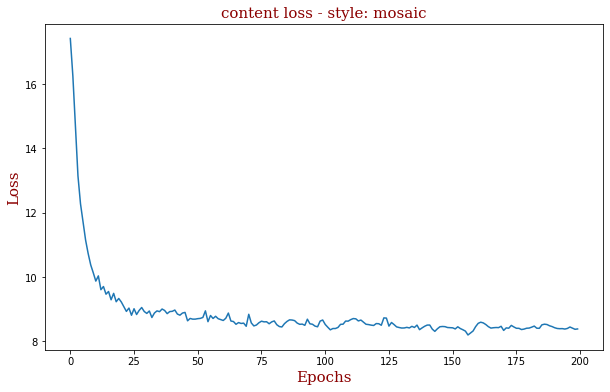

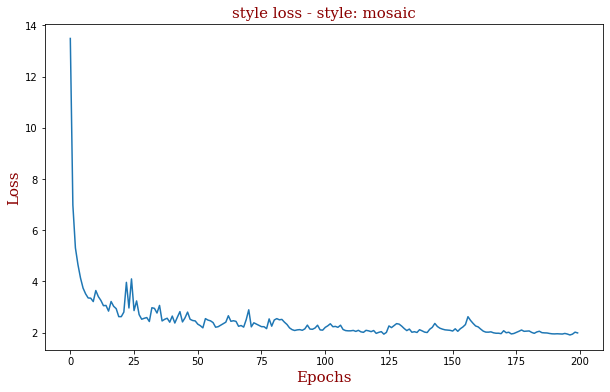

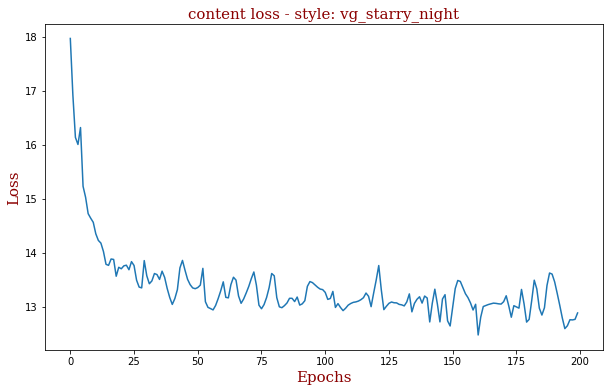

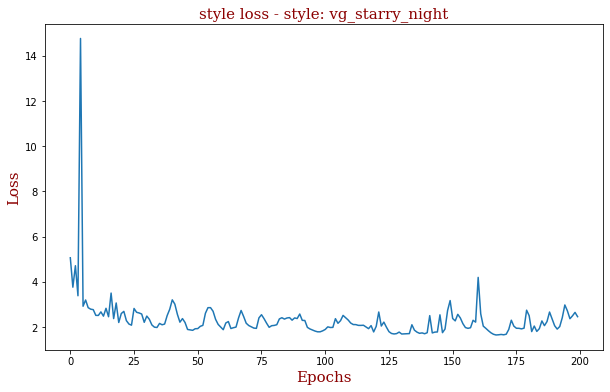

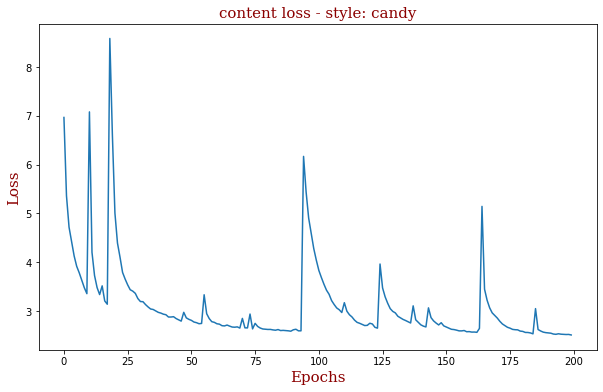

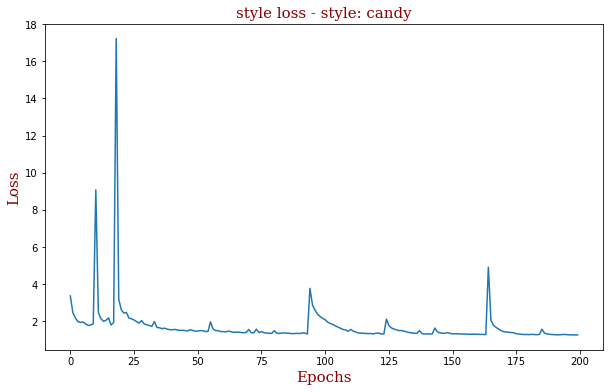

In [24]:
style_type = ['mosaic', 'vg_starry_night', 'candy']
for style in style_type:
    generate_nst_loss_plots(style, 'content')
    generate_nst_loss_plots(style, 'style')
    generate_nst_loss_plots(style, 'total')

In [10]:
# Mask R-CNN losses

mask_loss_dict = {'loss_classifier':[], 'loss_box_reg':[], 'loss_mask':[], 'loss_objectness':[], 'loss_rpn_box_reg':[]}
def generate_maskrcnn_loss_plots(mask_loss_dict):
    for i in range(1, 101):
        with open(os.getcwd() + f'/losses/loss/{i}.pkl', 'rb') as f:
            mask_loss = CPU_Unpickler(f).load()
        for key in mask_loss_dict.keys():
            mask_loss_dict[key].append(mask_loss[key])
    
    # font_style = {'family':'serif','color':'darkred','size':15}

    # for key, val in mask_loss_dict.items():  
    #     plt.figure(figsize = (10, 6))
    #     plt.xlabel("Epochs", fontdict = font_style)
    #     plt.ylabel("Loss", fontdict = font_style)  
    #     plt.title(f"{key}", fontdict = font_style)
    #     plt.plot(val)
    #     plt.savefig(f"graphs/{key}.png")
    #     plt.show()
    return mask_loss_dict

#generate_nst_loss_plots(mask_loss_dict)

In [11]:
mld = generate_maskrcnn_loss_plots(mask_loss_dict)

In [8]:
mld['loss_classifier'][0]

0.030470307916402817

In [12]:
total_loss = []
for i in range(0, 100):
    total_loss.append(mld['loss_classifier'][i] + mld['loss_box_reg'][i] + mld['loss_mask'][i] + mld['loss_objectness'][i] + mld['loss_rpn_box_reg'][i])

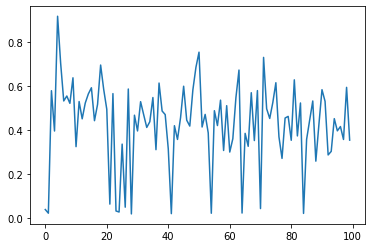

In [13]:
import matplotlib.pyplot as plt
plt.plot(total_loss)

In [4]:
temp = generate_maskrcnn_loss_plots(mask_loss_dict)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.array([epoch for epoch in range(1, 101)])
y = np.array(temp['loss_classifier'])
print(type(x))
print(type(y))
#yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, y)



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [2]:
import json
with open('metrics.json') as f:
    precision_file = json.load(f)

sorted_keys = sorted([int(key) for key in precision_file.keys()])
sorted_keys = [str(key) for key in sorted_keys]

In [3]:
precision_0_5 = []

for key in sorted_keys:
    precision_0_5.append(precision_file[key]['0.5'])

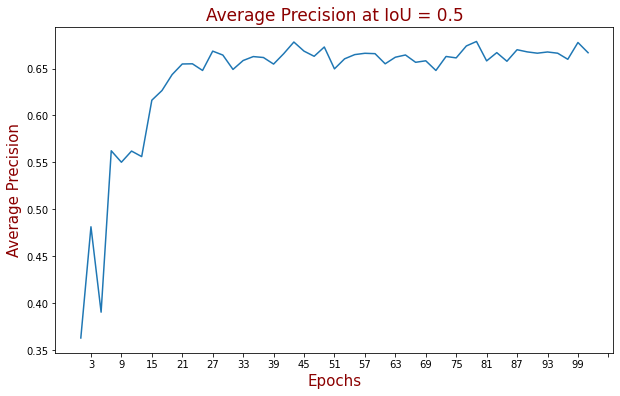

In [4]:
import matplotlib.pyplot as plt
import numpy as np

font_style = {'family':'sans-serif','color':'darkred','size':15}
font_style2 = {'family':'sans-serif','color':'darkred','size':17}

plt.figure(figsize = (10, 6))
plt.title("Average Precision at IoU = 0.5", fontdict=font_style2)
plt.xlabel("Epochs", fontdict=font_style)
plt.ylabel("Average Precision", fontdict=font_style)
plt.xticks(np.arange(1, 100, step=3))
plt.plot(sorted_keys, precision_0_5)
plt.xticks()

plt.show()

In [25]:
from statistics import mean
temp_list = []
import numpy as np
temp_list.append(mean(precision_file['51'].values()))
temp_list

[0.30882]

In [26]:
precision_average = []
for key in sorted_keys:
    precision_average.append(mean(precision_file[key].values()))

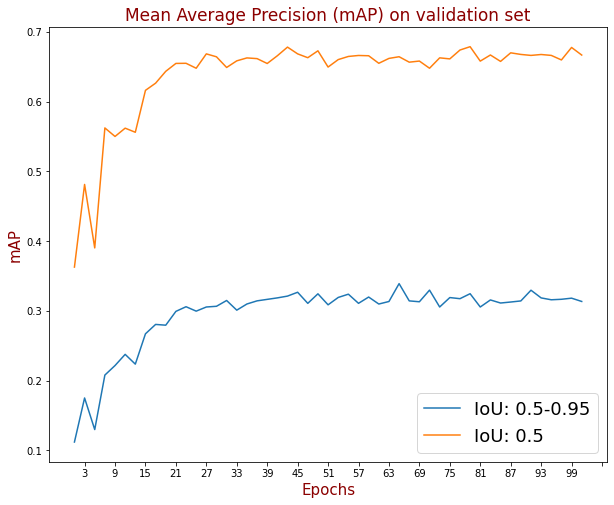

In [43]:
import matplotlib.pyplot as plt
import numpy as np

font_style = {'family':'sans-serif','color':'darkred','size':15}
font_style2 = {'family':'sans-serif','color':'darkred','size':17}

plt.figure(figsize = (10, 8))
plt.title("Mean Average Precision (mAP) on validation set", fontdict = font_style2)
plt.xlabel("Epochs", fontdict = font_style)
plt.ylabel("mAP", fontdict = font_style)
plt.xticks(np.arange(1, 100, step = 3))
plt.plot(sorted_keys, precision_average, label="IoU: 0.5-0.95")
plt.plot(sorted_keys, precision_0_5, label="IoU: 0.5")
plt.legend(loc = 'lower right', prop={'size': 18})
plt.xticks()

plt.show()